# Evaluación del caso “Binaria + planeta cerca del radio de Hill”

En esta sección medimos cómo afecta la optimización al exponente de Lyapunov del sistema.  
Partimos de un estado base (masas en el centro de sus `mass_bounds`) para obtener un λ de referencia y lo comparamos con el mejor individuo que devolvió el GA.  
Luego integramos la trayectoria con las masas óptimas y visualizamos el comportamiento de los tres cuerpos, poniendo especial atención a los encuentros cercanos del “planeta” con el binario.

> **Interpretación**
> - Un λ más pequeño indica una dinámica menos caótica.
> - El gráfico permite comprobar si el planeta logra mantenerse en órbita o si termina inestable por la proximidad al radio de Hill.


## Preparación del entorno
Aseguramos que el directorio raíz del proyecto esté disponible en `sys.path` para poder importar los módulos internos sin problemas, independientemente de desde dónde se ejecute el notebook.


In [1]:
import sys
from pathlib import Path

repo_root = Path.cwd().resolve().parents[1]  # …/collision_of_two_bodies
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))


## Dependencias principales
Importamos los componentes clave del pipeline:
- `Config` y utilidades de seeding.
- El controlador híbrido (GA + refinamiento).
- Herramientas de visualización y simulación REBOUND.
- `numpy` para cualquier análisis adicional.


In [2]:
from two_body import Config, set_global_seeds
from two_body.core.telemetry import setup_logger
from two_body.logic.controller import ContinuousOptimizationController
from two_body.presentation.visualization import Visualizer
from two_body.simulation.rebound_adapter import ReboundSim
import numpy as np


In [3]:
import logging
from IPython.display import display, Markdown

class NotebookHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        self.lines = []

    def emit(self, record):
        msg = self.format(record)
        self.lines.append(msg)
        print(msg)  # aparece en la celda conforme avanza

handler = NotebookHandler()
handler.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s"))

logger = setup_logger(level="DEBUG")
logger.handlers.clear()          # quita otros handlers previos
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)


## Configuración del escenario “Binaria + planeta cerca del radio de Hill”
Definimos la escena de estudio:
- Dos estrellas de masas distintas orbitando el baricentro.
- Un planeta tipo Júpiter ubicado cerca del radio de Hill.
- Hiperparámetros del GA y de la fase continua orientados a detectar combinaciones de masas que mitiguen el caos.


In [ ]:
# ["Binaria con planeta (Hill)"]
case = {
    # Simulación
    "t_end_short": 200.0,
    "t_end_long": 4000.0,
    "dt": 0.25,
    "integrator": "ias15",
    "r0": (
        (-0.333, 0.0, 0.0),   # estrella 1 (1.0) orbitando el baricentro
        (0.667, 0.0, 0.0),    # estrella 2 (0.5)
        (1.2, 0.0, 0.0),      # “planeta” ~Júpiter cerca del límite de Hill
    ),
    "v0": (
        (0.0, -0.912, 0.0),   # velocidad circular ajustada (signo opuesto a la otra estrella)
        (0.0, 1.824, 0.0),
        (0.0, 0.75, 0.0),     # ligeramente sub-circular para inducir encuentros
    ),

    # Parámetros físicos
    "mass_bounds": (
        (0.95, 1.05),         # estrella 1 alrededor de 1.0
        (0.45, 0.55),         # estrella 2 alrededor de 0.5
        (8e-4, 1.2e-3),       # planeta tipo Júpiter ~10⁻³
    ),
    "G": 1.0,
    "x0": (-0.333, 0.0, 0.0, -0.912, 0.667, 0.0, 0.0, 1.824),

    # Algoritmo genético
    "pop_size": 96,
    "n_gen_step": 4,
    "crossover": 0.85,
    "mutation": 0.25,
    "selection": "tournament",
    "elitism": 2,
    "seed": 321,

    # Optimización continua
    "max_epochs": 80,
    "top_k_long": 12,
    "stagnation_window": 6,
    "stagnation_tol": 5e-4,
    "local_radius": 0.03,    # radio pequeño: ajusta finamente las masas
    "radius_decay": 0.85,
    "time_budget_s": 1500.0,
    "eval_budget": 4500,

    # Backend / cache
    "use_gpu": "false",
    "batch_size": 128,
    "cache_exact_max": 500,
    "cache_approx_max": 1500,

    # I/O
    "artifacts_dir": "artifacts/hill_planet",
    "save_plots": True,
    "headless": False,
}


In [5]:
cfg = Config(**case)
set_global_seeds(cfg.seed)
logger = setup_logger()

## Ejecución del optimizador
Inicializamos el controlador con la configuración anterior, habilitamos el registro de eventos y lanzamos el proceso completo de optimización. Al finalizar, presentamos los logs capturados junto con el resultado agregado (mejor combinación de masas encontrada y métricas básicas).

In [7]:
controller = ContinuousOptimizationController(cfg, logger=logger)
results = controller.run()
display(Markdown("### Logs capturados"))
display("\n".join(handler.lines))
results

[2025-10-21 20:54:34,001] INFO - Starting optimization | pop=96 | dims=3 | time_budget=1500.0s | eval_budget=4500
[2025-10-21 20:54:37,754] INFO - Epoch 0 | new global best (short) λ≈ -0.000261 | masses=(0.976395, 0.456018, 0.000943)
[2025-10-21 20:54:47,241] INFO - Epoch 0 complete | λ_short≈ -0.000261 | evals short/long=96/12 | total evals=108 | radius=0.0300
[2025-10-21 20:55:00,588] INFO - Epoch 1 complete | λ_short≈ -0.000052 | evals short/long=96/12 | total evals=216 | radius=0.0300
[2025-10-21 20:55:13,499] INFO - Epoch 2 complete | λ_short≈ -0.000239 | evals short/long=96/12 | total evals=324 | radius=0.0300
[2025-10-21 20:55:26,848] INFO - Epoch 3 complete | λ_short≈ 0.000173 | evals short/long=96/12 | total evals=432 | radius=0.0300
[2025-10-21 20:55:39,832] INFO - Epoch 4 complete | λ_short≈ 0.000015 | evals short/long=96/12 | total evals=540 | radius=0.0300
[2025-10-21 20:55:52,727] INFO - Epoch 5 complete | λ_short≈ -0.000098 | evals short/long=96/12 | total evals=648 | ra

### Logs capturados

'[2025-10-21 20:52:45,331] INFO - Starting optimization | pop=96 | dims=3 | time_budget=1500.0s | eval_budget=4500\n[2025-10-21 20:52:49,219] INFO - Epoch 0 | new global best (short) λ≈ 0.000063 | masses=(1.041211, 0.454312, 0.00095)\n[2025-10-21 20:52:57,881] INFO - Epoch 0 | new global best (long) λ≈ 0.000000 | masses=(1.041211, 0.454312, 0.00095)\n[2025-10-21 20:52:57,881] INFO - Epoch 0 | new global best (long) λ≈ -0.000003 | masses=(1.027446, 0.465782, 0.00084)\n[2025-10-21 20:52:57,881] INFO - Epoch 0 complete | λ_short≈ 0.000063 | evals short/long=96/12 | total evals=108 | radius=0.0300\n[2025-10-21 20:53:01,566] INFO - Epoch 1 | new global best (short) λ≈ -0.000224 | masses=(1.043921, 0.545591, 0.000873)\n[2025-10-21 20:53:10,797] INFO - Epoch 1 complete | λ_short≈ -0.000224 | evals short/long=96/12 | total evals=216 | radius=0.0300\n[2025-10-21 20:53:23,308] INFO - Epoch 2 complete | λ_short≈ -0.000052 | evals short/long=96/12 | total evals=324 | radius=0.0300\n[2025-10-21 20:

{'status': 'completed',
 'best': {'masses': [1.041211032216705,
   0.45419474332579357,
   0.0009503809646476818],
  'lambda': -0.0005658586991704906,
  'fitness': 0.0005658586991704906,
  'm1': 1.041211032216705,
  'm2': 0.45419474332579357,
  'm3': 0.0009503809646476818},
 'evals': 4536,
 'epochs': 42}

## Evaluación comparativa y visualización
Contrastamos el exponente de Lyapunov del estado base (masas en la mitad de sus rangos) contra el obtenido por la solución optimizada. Por último, integramos la dinámica con las masas ganadoras para visualizar la trayectoria de los tres cuerpos y observar el comportamiento cerca del límite de estabilidad.


λ inicial = -0.000004, λ óptimo = -0.000566


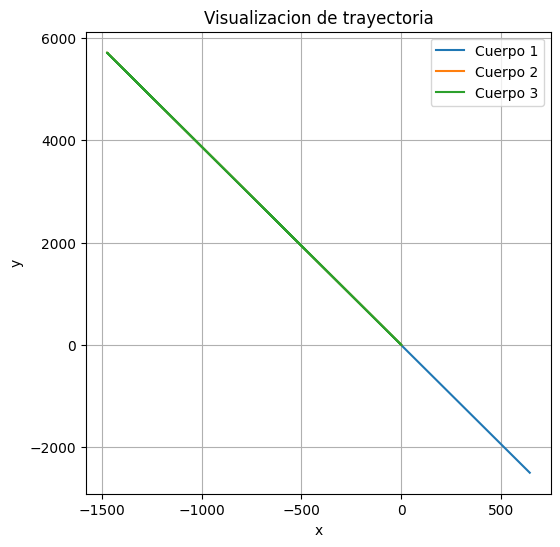

In [8]:
from two_body.logic.fitness import FitnessEvaluator
from two_body.core.cache import HierarchicalCache
from two_body.simulation.rebound_adapter import ReboundSim

cache = HierarchicalCache()
evaluator = FitnessEvaluator(cache, cfg)

center = tuple((lo + hi) / 2.0 for lo, hi in cfg.mass_bounds)
baseline = evaluator.evaluate_batch([center], horizon="long")[0]
best_fit = results["best"]["fitness"]

print(f"λ inicial = {-baseline:.6f}, λ óptimo = {-best_fit:.6f}")

sim_cls = ReboundSim

sim_builder = sim_cls(G=cfg.G, integrator=cfg.integrator)
sim = sim_builder.setup_simulation(tuple(results["best"]["masses"]), cfg.r0, cfg.v0)
traj = sim_builder.integrate(sim, t_end=cfg.t_end_long, dt=cfg.dt)

viz = Visualizer(headless=cfg.headless)
viz.quick_view([traj[:, i, :3] for i in range(traj.shape[1])])
